In [1]:
import csv
import datetime
import os
import random

import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from IPython.display import Image



Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [3]:
random.seed(34283428)
base_dir_path = '.'
best_model_filepath = '{}/saved-models/model1.hdf5'.format(base_dir_path)


In [4]:
# Parameters
training_epochs = 1

In [5]:
start_time = datetime.datetime.utcnow()
print(".. loading & splitting data ..")

image_to_label = {}
images_list = []
label_list = []
with open('{base_dir_path}/data-labels/images.csv'.format(base_dir_path=base_dir_path),
          newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        image_name = row['IMAGE FILENAME'].strip()
        is_huddle = 1 if row['IS HUDDLE'] else 0
        if image_name:
            image_path = '{base_dir_path}/data-images/{image_name}'.format(base_dir_path=base_dir_path,
                                                                           image_name=image_name)
            image_to_label[image_path] = is_huddle
            images_list.append(image_path)
            label_list.append(is_huddle)


.. loading & splitting data ..


In [14]:
label_list_categorical = to_categorical(label_list)

X_train, X_test, y_train, y_test = train_test_split(np.array(images_list),
                                                    np.array(label_list_categorical),
                                                    test_size=0.20,
                                                    random_state=42)

X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.20,
                                                            random_state=42)

train_tensors = paths_to_tensor(X_train).astype('float32')
test_tensors = paths_to_tensor(X_test).astype('float32')
valid_tensors = paths_to_tensor(X_validate).astype('float32')

loading_finished_time = datetime.datetime.utcnow()
duration_loading = (loading_finished_time - start_time).total_seconds()


100%|██████████| 224/224 [00:01<00:00, 142.60it/s]


In [15]:
print(".. constructing the model ..")

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=2, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=2, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


.. constructing the model ..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 3

In [16]:
print(".. training the model ..")

checkpointer = ModelCheckpoint(filepath=best_model_filepath,
                               verbose=1,
                               save_best_only=True)

model.fit(train_tensors, y_train,
          validation_data=(valid_tensors, y_validate),
          epochs=training_epochs,
          batch_size=20,
          callbacks=[checkpointer],
          verbose=1)

training_finished_time = datetime.datetime.utcnow()
duration_training = (training_finished_time - loading_finished_time).total_seconds()


.. training the model ..
Train on 896 samples, validate on 224 samples
Epoch 1/1
896/896 [==============================] - 125s 140ms/step - loss: 0.5101 - acc: 0.7444 - val_loss: 0.3599 - val_acc: 0.8482

Epoch 00001: val_loss improved from inf to 0.35985, saving model to ./saved-models/model1.hdf5


In [29]:
print(".. loading best weights ..")

model.load_weights(best_model_filepath)

print(".. testing the model ..")

tmp_predictions = [model.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]
test_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

testing_finished_time = datetime.datetime.utcnow()
duration_testing = (testing_finished_time - training_finished_time).total_seconds()

print(".. reporting results ..")

true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
all_positives = 0
all = len(X_test)

false_positive_images = []
false_negative_images = []

for n, test_image in enumerate(X_test):
    prediction_label = True if test_predictions[n] else False
    truth_label = True if y_test[n][1] else False
    correct_prediction = prediction_label == truth_label

#     print("{indicator} {truth_icon} {test_image} (is {truth} predicted {prediction})".format(
#         indicator=' ' if correct_prediction else 'X',
#         truth_icon='|' if truth_label else '=',
#         test_image=test_image,
#         truth=truth_label,
#         prediction=prediction_label,
#     ))

    if truth_label:
        all_positives += 1

    if prediction_label:
        if truth_label:
            true_positives += 1
        else:
            false_positives += 1
            false_positive_images.append(test_image)
    else:
        if truth_label:
            false_negatives += 1
            false_negative_images.append(test_image)
        else:
            true_negatives += 1
            
            

.. loading best weights ..
.. testing the model ..
.. reporting results ..


In [30]:
print("loading duration: {0:.1f} seconds".format(duration_loading))
print("training duration: {0:.1f} seconds".format(duration_training))
print("testing duration: {0:.1f} seconds".format(duration_testing))

print("all: ", all)
print("all_positives: ", all_positives)
print("true_positives: ", true_positives)
print("true_negatives: ", true_negatives)
print("false_positives: ", false_positives)
print("false_negatives: ", false_negatives)

print("RECALL: {0:.2f}%".format(100 * true_positives / all_positives))
print("ACCURACY: {0:.2f}%".format(100 * (true_positives + true_negatives) / all))


loading duration: 102.6 seconds
training duration: 165.1 seconds
testing duration: 451.9 seconds
all:  280
all_positives:  60
true_positives:  40
true_negatives:  196
false_positives:  24
false_negatives:  20
RECALL: 66.67%
ACCURACY: 84.29%


## False Positives:

./data-images/5831137888001-117.jpg:


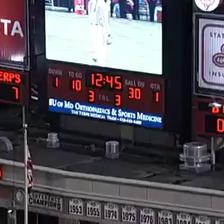

./data-images/5833084561001-1351.jpg:


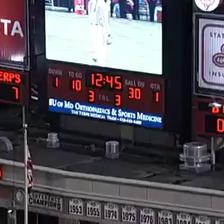

./data-images/5831138807001-758.jpg:


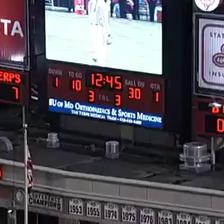

./data-images/5831138807001-1266.jpg:


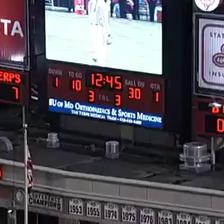

./data-images/5831135399001-314.jpg:


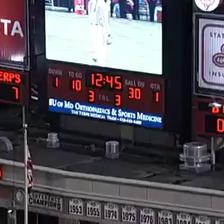

./data-images/5831137888001-1522.jpg:


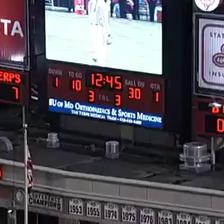

./data-images/5831135399001-883.jpg:


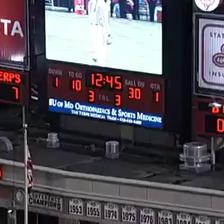

./data-images/5831137888001-531.jpg:


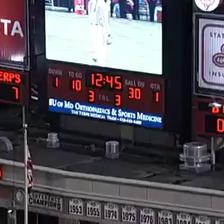

./data-images/5833096735001-397.jpg:


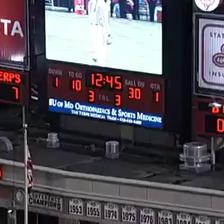

./data-images/5833096735001-1604.jpg:


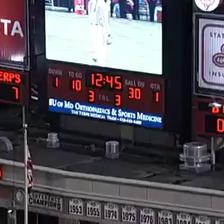

In [31]:
for image_path in false_positive_images[:10]:
    print("{}:".format(image_path))
    display(Image(filename=images_list[0]))

## False Netatives:

./data-images/5831139883001-718.jpg:


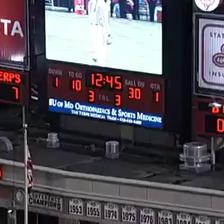

./data-images/5831139883001-1638.jpg:


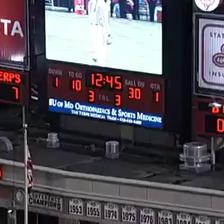

./data-images/5831139883001-224.jpg:


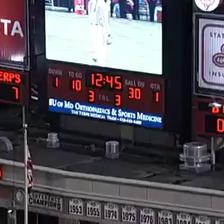

./data-images/5831139883001-1337.jpg:


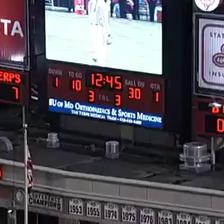

./data-images/5833084561001-1562.jpg:


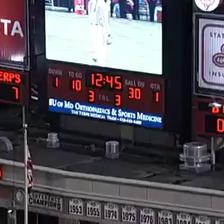

./data-images/5833090951001-459.jpg:


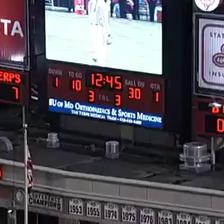

./data-images/5833084561001-804.jpg:


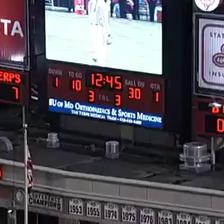

./data-images/5833084561001-1821.jpg:


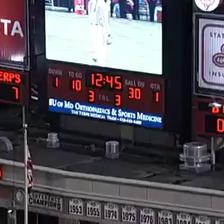

./data-images/5831139883001-1828.jpg:


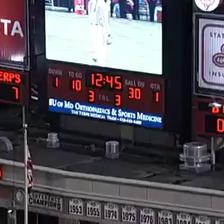

./data-images/5831137888001-479.jpg:


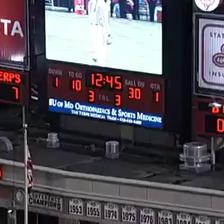

In [32]:
for image_path in false_negative_images[:10]:
    print("{}:".format(image_path))
    display(Image(filename=images_list[0]))